# Orbit and stream simulation
## Base potential model: MWPotential2014

# 1. Orbit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from astropy import units
from astropy.io import ascii
import corner
from plot_functions import *

from galpy.orbit import Orbit
from galpy.util.conversion import get_physical
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf
from galpy.potential.mwpotentials import McMillan17

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# params imported from plot_functions
params['xtick.labelsize'] = 12
params['ytick.labelsize'] = 12
params['axes.labelsize'] = 12
params['axes.titlesize'] = 14
plt.rcParams.update(params)

### Data from other sources

In [3]:
styx_trace = ascii.read('styx.trace')

# from Dr. Erkal
data_wlmc = ascii.read('dwarf_stream_bootes_3_wLMC.txt')
data_wolmc = ascii.read('dwarf_stream_bootes_3_woLMC.txt')

## Functions

Note a few physical values from galpy's default configuration:
- Solar radius R = 8 kpc
- Circular velocity V = 220 km/s
- Solar motion [Schoenrich 2010](http://adsabs.harvard.edu/abs/2010MNRAS.403.1829S)

In [4]:
SOLAR_MOTION = [-11.1, 12.24, 7.25]

In [5]:
def get_total_potential(base_potential, forward=False):
    """Return a potential that combines <base_potential> with
    the LMC's potential, plus a non-inertial frame force (the MW's 
    reflex motion in response to the LMC's infall).
    
    The potential created is only valid for 5 Gyr in forward/backward 
    modelling. If <forward> is True, the potential is created for
    forward integration.
    
    Note: 
    - The <rscale> variable defined below is the "scale radius",
      which is the variable (a) found in Eq. 3 from Hernquist 1990.
    - The <rhm> variable is the "half-mass radius", its relation
      with the scale radius is given by: rhm = a * (1 + sqrt(2))
    """
    mass_lmc = 1.38e11               # M_sun
    rscale = 16.09                   # kpc
    rhm = rscale * (1 + np.sqrt(2))  # kpc
    
    # Define LMC orbit object and dynamical friction force
    # Then, integrate the LMC orbit and turn it into a moving potential model.
    orbit_LMC = Orbit.from_name('LMC', solarmotion=SOLAR_MOTION, **get_physical(base_potential))
    
    if base_potential == McMillan17:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc,
                                                  dens=base_potential[1],
                                                  **get_physical(base_potential))
    else:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc,
                                                  **get_physical(base_potential))

    ts = np.linspace(0, 5, 1001)*units.Gyr  # fixed timescale
    if forward:
        orbit_LMC.integrate(ts, base_potential + cdf)
    else:
        orbit_LMC.integrate(-ts, base_potential + cdf)
        
    lmcpot = HernquistPotential(amp=2*mass_lmc*units.Msun, a=rscale*units.kpc, **get_physical(base_potential))
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot, **get_physical(base_potential))

    # Create the MW barycentric acceleration
    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return base_potential + nip + moving_lmcpot

In [6]:
def ax_plot_realizations(ax, component_for_x, component_for_y):
    """
    **Required for generate_orbit_model**
    
    Take every 10th element in <component_for_x> and <component_for_y>, which are
    attributes of an Orbit instance that contains many orbits, and plot them onto <ax>.
    
    This is for convenient plotting of the many realizations of orbits made to account
    for the 6D parameters uncertainties.
    """
    for (x, y) in zip(component_for_x[::10], component_for_y[::10]):
        ax.plot(x, y, c='deepskyblue', alpha=0.1, zorder=1)

    
def generate_orbit_model(params_6D, errors_6D, max_time, base_potential,
                         potential_forward, potential_backward,
                         solar_motion=SOLAR_MOTION, num_of_realizations=1000, 
                         skip_forward=False, plots_only=False, save_plots=False, 
                         title_text='', save_text=''):
    """The complete function for integrating and displaying the orbit.
    
    Note: Separate potential variables are required for forward and 
    backward modelling, because the LMC is a moving potential, so 
    backward potential requires the rewind orbit of LMC.
    
    Parameters
    ----------
    params_6D:
        The 6D phase-space parameters of the dwarf galaxy. 
        In this order, [ra, dec, distance, pmra, pmdec, velocity].
    errors_6D:
        The uncertainties for the 6D parameters. 
        Enter 0 for the parameters that do not have uncertainties.
    max_time:
        The time (in Gyr) for the integration to run until. 
        This is used to create a numpy array for the timescale.
    base_potential:
        A galpy built-in potential model.
        This should be the one that was used to create 
        <potential_forward> and <potential_backward>.
    potential_forward:
        A custom potential model including the LMC and MW reflex motion.
        For forward integration only.
    potential_backward:
        Similar as above, but for backward integration.
    solar_motion:
        The same solar motion parameter as in galpy.
        This is an option to change the total solar velocity V_phi, 
        which is an empirical value important for coordinate conversions.
    num_of_realizations:
        The number of orbits to generate given the uncertainties on
        the 6D parameters.
    skip_forward:
        If true, skip the forward integration 
        (the returned forward parts will not work).
    plots_only:
        If true, return no values and only generate a plot.
    save_plots:
        If true, save the plot with the file name as <save_text>.
    title_text:
        The title of the plot.
    save_text:
        The file name of the saved plot.
    
    Return
    ------
    If <plots_only> is False (default):
        Return the galpy Orbit objects that represent the model result.
        This includes the forward orbit, backward orbit, their 
        different realizations, and the timescale array.
    If <plots_only> is True:
        Return nothing.
        Only show the plots of the orbit integration.
    """
    # Prepare the parameters for the realizations
    params_6D_many = np.random.normal(loc=params_6D, scale=errors_6D, 
                                      size=(num_of_realizations, 6))
    # Make timescale
    ts = np.linspace(0, max_time, 1001) * units.Gyr

    # Create orbits
    orbit_forward = Orbit(params_6D, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    orbit_backward = Orbit(params_6D, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    orbit_forward_many = Orbit(params_6D_many, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    orbit_backward_many = Orbit(params_6D_many, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    
    # Integrate
    orbit_forward.integrate(ts, potential_forward)
    orbit_backward.integrate(-ts, potential_backward)
    orbit_forward_many.integrate(ts, potential_forward)
    orbit_backward_many.integrate(-ts, potential_backward)
    
    # Plot in this order: XY-plane, XZ-plane, YZ-plane, and R vs. t
    fig, axs = plt.subplots(1, 4, figsize=(12.4, 3))

    for ax, plane in zip(axs, ['XY', 'XZ', 'YZ', 'RT']):
        # Determine what we are plotting
        if plane == 'XY':
            xf, yf = orbit_forward.x(ts), orbit_forward.y(ts)                        # "forward"
            xb, yb = orbit_backward.x(-ts), orbit_backward.y(-ts)                    # "backward" 
            xf_err, yf_err = orbit_forward_many.x(ts), orbit_forward_many.y(ts)      # their "errors"
            xb_err, yb_err = orbit_backward_many.x(-ts), orbit_backward_many.y(-ts)
        elif plane == 'XZ':
            xf, yf = orbit_forward.x(ts), orbit_forward.z(ts)
            xb, yb = orbit_backward.x(-ts), orbit_backward.z(-ts)
            xf_err, yf_err = orbit_forward_many.x(ts), orbit_forward_many.z(ts)
            xb_err, yb_err = orbit_backward_many.x(-ts), orbit_backward_many.z(-ts)
        elif plane == 'YZ':
            xf, yf = orbit_forward.y(ts), orbit_forward.z(ts)
            xb, yb = orbit_backward.y(-ts), orbit_backward.z(-ts)
            xf_err, yf_err = orbit_forward_many.y(ts), orbit_forward_many.z(ts)
            xb_err, yb_err = orbit_backward_many.y(-ts), orbit_backward_many.z(-ts)
        else:
            # No need the forward part for R vs. t
            skip_forward = True
            xb, yb = orbit_backward.time(-ts), orbit_backward.r(-ts)
            xb_err = np.tile(orbit_backward_many.time(-ts), (num_of_realizations, 1))
            yb_err = orbit_backward_many.r(-ts)

        # forward
        if not skip_forward:
            ax.plot(xf, yf, c='k', ls='-', zorder=2)
            ax_plot_realizations(ax, xf_err, yf_err)
        # backward
        ax.plot(xb, yb, c='k', ls='--', zorder=2)
        ax_plot_realizations(ax, xb_err, yb_err)

        ax.plot(xb[0], yb[0], 'ok', zorder=2)
        if plane != 'RT':
            ax.set_xlabel(plane[0] + ' [kpc]')
            ax.set_ylabel(plane[1] + ' [kpc]')
            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
        else:
            ax.set_xlabel('t [Gyr]')
            ax.set_ylabel('R [kpc]')
            ax.set_ylim(0, 230)

        ax.set_aspect('auto')

    plt.tight_layout()
    plt.suptitle(title_text, y=1.05)
    if save_plots:
        fig.savefig(f'{save_text}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    if not plots_only:
        return orbit_forward, orbit_backward, orbit_forward_many, orbit_backward_many, ts
    else:
        return

### Input setup

In [7]:
# 6D parameters
RA_BOO3 = 209.3     # deg  (from Grillmair 2009)
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc  (from Carlin 2018)
PMRA_BOO3 = -1.16   # mas yr^-1  (from Part 1 of this work)
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 191.31   # km s^-1

# Uncertainties (no value for positions)
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 0.75  

boo3_6D = [RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3]
boo3_6D_err = [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3]

## MWPotential2014

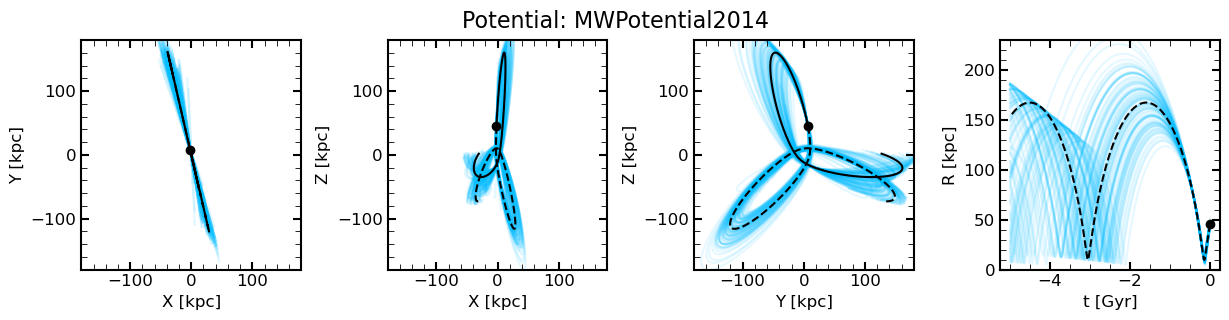

In [10]:
result = generate_orbit_model(params_6D=boo3_6D, errors_6D=boo3_6D_err, max_time=5, 
                              base_potential=MWPotential2014, 
                              potential_forward=MWPotential2014,
                              potential_backward=MWPotential2014,
                              save_plots=True,
                              title_text='Potential: MWPotential2014', 
                              save_text='orbit_MWPotential2014')

orbit_forward, orbit_backward, orbit_forward_many, orbit_backward_many, ts = result

## MWPotential2014 + LMC + reflex motion (barycentric acceleration)

In [13]:
total_potential_backward = get_total_potential(MWPotential2014)
total_potential_forward = get_total_potential(MWPotential2014, forward=True)

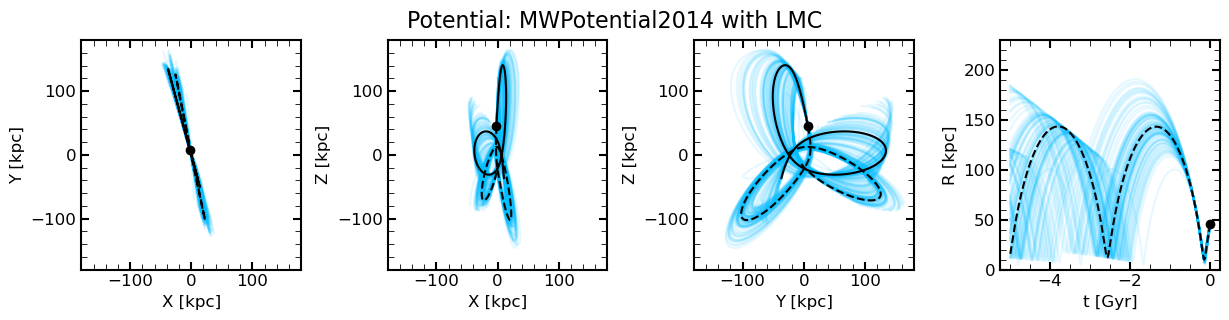

In [14]:
result2 = generate_orbit_model(params_6D=boo3_6D, errors_6D=boo3_6D_err, max_time=5, 
                              base_potential=MWPotential2014, 
                              potential_forward=total_potential_forward,
                              potential_backward=total_potential_backward,
                              save_plots=True,
                              title_text='Potential: MWPotential2014 with LMC', 
                              save_text='orbit_MWPotential2014_LMC')

orbit_forward2, orbit_backward2, orbit_forward_many2, orbit_backward_many2, ts2 = result2

## Orbital properties

For getting the most recent pericenter and apocenter, we can't use the built-in rperi() and rap() because they take the global extremum values. We will use a scipy trick to get the indices of all pericenters and apocenters, and take the first index.

The commented lines will show the difference between using the scipy trick and using rperi() and rap(). The latter result *may not be* the most recent pericenter and apocenter passages.

In [15]:
def generate_peri_apo_distributions(orbits, ts, get_peri_time=False, fig_title='', save_title=''):
    """Note: there's some added code that calculates the time of pericenter occurrence.
    For this particular setup I know the time array is in Gyr (astropy Quantity), but it will
    be wrong if the input timescale <ts> is in other units, watch out for that
    """
    all_peri = []
    all_apo = []
    time_of_peri = []
    time_of_apo = []
    for orbit in orbits:
        peri_index = argrelextrema(orbit.r(-ts), np.less)[0][0]
        apo_index = argrelextrema(orbit.r(-ts), np.greater)[0][0]
        all_peri.append(orbit.r(-ts)[peri_index])
        all_apo.append(orbit.r(-ts)[apo_index])
        
        # This line will give wrong results if time is not in Gyr!
        time_of_peri.append(-ts[peri_index].value)

    figure = corner.corner(np.vstack((all_peri, all_apo, orbits.e())).T,
                       labels=['$r_\mathrm{peri}$', '$r_\mathrm{apo}$', '$e$'],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True,
                       #plot_datapoints=False,
                       title_kwargs={"fontsize": 13},
                       label_kwargs = dict(fontsize=15),
                       #range=[[np.array(all_peri).min(), np.array(all_peri).max()], [np.array(all_apo).min(), np.array(all_apo).max()], [0.87, orbits.e().max()]],
                       ls='--', c='gray')
    figure.set_size_inches(6, 6)
    
    axes = figure.get_axes()
    axes[0].text(3, 0.5, fig_title, fontsize=14, ha='right', va='top', transform=axes[0].transAxes)
    figure.savefig(save_title, dpi=300, bbox_inches='tight')
    plt.show()
    
    if get_peri_time:
        return time_of_peri

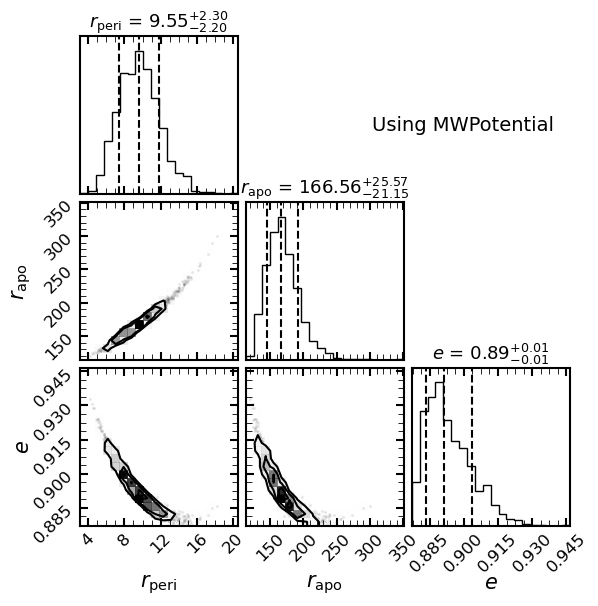

In [16]:
time_of_peri = generate_peri_apo_distributions(orbit_backward_many, ts, 
                                               get_peri_time=True,
                                               fig_title='Using MWPotential', 
                                               save_title='orbit_params_nolmc.png')

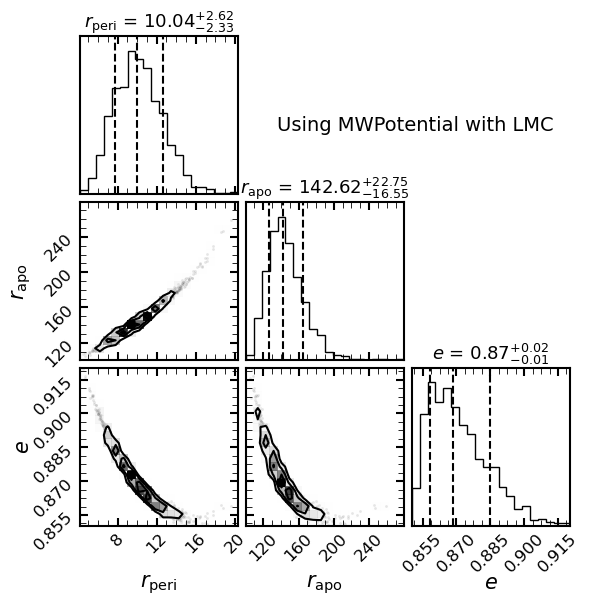

In [17]:
time_of_peri2 = generate_peri_apo_distributions(orbit_backward_many2, ts2,
                                                get_peri_time=True,
                                                fig_title='Using MWPotential with LMC', 
                                                save_title='orbit_params_wlmc.png')

In [18]:
import uncertainties

def get_median_with_errors(data):
    median = np.percentile(data, 50)
    error1 = np.percentile(data, 50) - np.percentile(data, 16)
    error2 = np.percentile(data, 84) - np.percentile(data, 50)
    error = (error1 + error2) / 2
    
    return uncertainties.ufloat(median, error)

time_of_peri = np.array(time_of_peri)
time_of_peri2 = np.array(time_of_peri2)

t_peri = get_median_with_errors(time_of_peri)    # Gyr
t_peri2 = get_median_with_errors(time_of_peri2)  # Gyr

vlos_disp = uncertainties.ufloat(1.88, 0.79)  # km/s

Time is in `Gyr`, velocity dispersion is in `km/s`. Both have uncertainties. Let's do some manual unit conversions and multiply them.

In [19]:
# flip the sign for the negative time
# convert Gyr to seconds
# convert km to parsec

dist = -t_peri * vlos_disp * 3.1536e16 / 3.086e13
dist2 = -t_peri2 * vlos_disp * 3.1536e16 / 3.086e13

print(f"Without LMC\nThe radius of the bound region of the system: {dist:.2f} [parsec]")
print(f"With LMC\nThe radius of the bound region of the system: {dist2:.2f} [parsec]")

Without LMC
The radius of the bound region of the system: 268.97+/-113.43 [parsec]
With LMC
The radius of the bound region of the system: 278.57+/-117.94 [parsec]


# 2. Stream

We create many variations of stream models. The **Default** setting is this:

| Parameter Name         | Quantity                        |
|------------------------|---------------------------------|
| Progenitor mass        | $10^7~M_\odot$                  |
| Galactic Potential     | MWPotential2014 with LMC |
| LMC mass               | $1.38 \times 10^{11}~\mathrm{M}_\odot$ |
| LMC half-mass radius   | 38.84 kpc                       |
| Time of Disruption     | 3 Gyr                           |
| Total velocity $V_\phi$ | $232.24~\mathrm{km~s}^{-1}$     |

And `solarmotion = [-11.1, 12.24, 7.25]`.

Then, we create these versions of the stream. The variable names use the following numbers accordingly.
1. Default
2. Default with LMC mass x2
3. Default with LMC rhm x2
4. Default with MW halo mass x1.5
5. Default with MW halo mass x2
6. Default with vphi = 245 (v_sun changed to 25)
7. Default without LMC
8. Default without LMC and with vphi = 245
9. Default BUT using McMillan17 (this also has vphi = 245)

In [12]:
def _get_potential_for_stream(base_potential, lmc_mass_factor=1, rhm_factor=1, mw_mass_factor=1, solar_motion=SOLAR_MOTION, forward=False):
    """Private function for generate_stream_model(). See description for get_total_potential().
    
    NOTE: <base_potential> will be modified!
    
    Three additional options:
    1. Increase LMC mass by <lmc_mass_factor>
    2. Increase LMC half-mass radius by <rhm_factor>
    3. Increase base potential model mass by <mw_mass_factor>
    """
    mass_lmc = 1.38e11               # M_sun
    rscale = 16.09                   # kpc
    rhm = rscale * (1 + np.sqrt(2))  # kpc
    
    # ---- The only addition compared to get_total_potential() ---- #
    mass_lmc *= lmc_mass_factor
    rhm *= rhm_factor
    base_potential[2] *= mw_mass_factor
    # ------------------------------------------------------------- #
    
    # Define LMC orbit object and dynamical friction force
    # Then, integrate the LMC orbit and turn it into a moving potential model.
    orbit_LMC = Orbit.from_name('LMC', solarmotion=SOLAR_MOTION, **get_physical(base_potential))
    
    if base_potential == McMillan17:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc,
                                                  dens=base_potential[1],
                                                  **get_physical(base_potential))
    else:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc,
                                                  **get_physical(base_potential))

    ts = np.linspace(0, 5, 1001)*units.Gyr  # fixed timescale
    if forward:
        orbit_LMC.integrate(ts, base_potential + cdf)
    else:
        orbit_LMC.integrate(-ts, base_potential + cdf)
        
    lmcpot = HernquistPotential(amp=2*mass_lmc*units.Msun, a=rscale*units.kpc, **get_physical(base_potential))
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot, **get_physical(base_potential))

    # Create the MW barycentric acceleration
    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return base_potential + nip + moving_lmcpot


def generate_stream_model(base_potential, progenitor_mass, tdisrupt, use_LMC=False,
                          lmc_mass_factor=1, rhm_factor=1, mw_mass_factor=1, solar_motion=SOLAR_MOTION):
    """The <base_potential> entered can be modified.
    Please pass in a copy of the potential instead of the original.
    This is a flaw in the code structure but it probably 
    won't be used again so I'm leaving it for now.
    """
    orbit_boo3 = Orbit(boo3_6D, radec=True, solarmotion=solar_motion)
    
    if use_LMC:
        potential = _get_potential_for_stream(base_potential, lmc_mass_factor, rhm_factor, mw_mass_factor, solar_motion)

        # Leading arm
        spdf = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                             progenitor = orbit_boo3,
                             pot = potential,
                             tdisrupt = tdisrupt * units.Gyr,
                             rtpot = base_potential)

        # Trailing arm
        spdft = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                              progenitor = orbit_boo3,
                              pot = potential,
                              tdisrupt = tdisrupt * units.Gyr,
                              rtpot = base_potential,
                              leading = False)
    else:
        # If we did not use the _get_potential_for_stream() function but 
        # still request the potential mass to be changed, we do that here
        base_potential[2] *= mw_mass_factor
        
        spdf = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                             progenitor = orbit_boo3,
                             pot = base_potential,
                             tdisrupt = tdisrupt * units.Gyr)
        spdft = streamspraydf(progenitor_mass = progenitor_mass * units.M_sun,
                              progenitor = orbit_boo3,
                              pot = base_potential,
                              tdisrupt = tdisrupt * units.Gyr,
                              leading = False)
        
    orbit_leading = spdf.sample(n=200, integrate=True)
    orbit_trailing = spdft.sample(n=200, integrate=True)
    
    return orbit_leading, orbit_trailing

## Generating

In [10]:
import warnings
from galpy.util import galpyWarning
warnings.filterwarnings('ignore', category=galpyWarning)

In [13]:
print("Running simulations...")
print("Progress: 0/9", end='\r')

# ----------------------------------- 1. Default --------------------------------- #
orbit_leading1, orbit_trailing1 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True)
print("Progress: 1/9", end='\r')

# -------------------------- 2. Default with LMC mass x2 ------------------------- #
orbit_leading2, orbit_trailing2 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        lmc_mass_factor=2)
print("Progress: 2/9", end='\r')

# ----------------------------- 3. Default with LMC rhm x2 ----------------------- #
orbit_leading3, orbit_trailing3 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        rhm_factor=2)
print("Progress: 3/9", end='\r')

# ----------------------- 4. Default with MW halo mass x1.5 ------------------------ #
MWPotential_copy = MWPotential2014.copy()

orbit_leading4, orbit_trailing4 = generate_stream_model(base_potential=MWPotential_copy,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        mw_mass_factor=1.5)
print("Progress: 4/9", end='\r')

# ----------------------- 5. Default with MW halo mass x2 ------------------------ #
MWPotential_copy2 = MWPotential2014.copy()

orbit_leading5, orbit_trailing5 = generate_stream_model(base_potential=MWPotential_copy2,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        mw_mass_factor=2)
print("Progress: 5/9", end='\r')

# --------------- 6. Default with vphi = 245 (v_sun changed to 25) --------------- #
orbit_leading6, orbit_trailing6 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True,
                                                        solar_motion=[-11.1, 25, 7.25])
print("Progress: 6/9", end='\r')

# ---------------------------- 7. Default without LMC ---------------------------- #
orbit_leading7, orbit_trailing7 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=False)
print("Progress: 7/9", end='\r')

# ----------------- 8. Default without LMC and with vphi = 245 ------------------- #
orbit_leading8, orbit_trailing8 = generate_stream_model(base_potential=MWPotential2014,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=False,
                                                        solar_motion=[-11.1, 25, 7.25])
print("Progress: 8/9", end='\r')

# ---------- 9. Default BUT using McMillan17 (this also has vphi = 245) ---------- #
orbit_leading9, orbit_trailing9 = generate_stream_model(base_potential=McMillan17,
                                                        progenitor_mass=1e7,
                                                        tdisrupt=3,
                                                        use_LMC=True)
print("Progress: 9/9")
print("Complete!")

Running simulations...
Progress: 9/9
Complete!


In [14]:
import pickle

In [17]:
orbit_settings = ["fiducial", "LMC_massX2", "LMC_radiusX2", "MW_massX1-5", "MW_massX2",
                  "Vphi_245", "nolmc", "nolmc_Vphi_245", "McMillan17"]

In [18]:
orbit_results = [[orbit_leading1, orbit_trailing1],
                 [orbit_leading2, orbit_trailing2],
                 [orbit_leading3, orbit_trailing3],
                 [orbit_leading4, orbit_trailing4],
                 [orbit_leading5, orbit_trailing5],
                 [orbit_leading6, orbit_trailing6],
                 [orbit_leading7, orbit_trailing7],
                 [orbit_leading8, orbit_trailing8],
                 [orbit_leading9, orbit_trailing9]]

for i in range(len(orbit_results)):
    fileObj = open(f'orbit_lead_{orbit_settings[i]}.obj', 'wb')
    pickle.dump(orbit_results[i][0], fileObj)
    fileObj.close()
    # Saving trailing part
    fileObj = open(f'orbit_trail_{orbit_settings[i]}.obj', 'wb')
    pickle.dump(orbit_results[i][1], fileObj)
    fileObj.close()

In [19]:
orbit_results = [[] for _ in range(9)]

for i in range(len(orbit_settings)):
    with open(f'orbit_lead_{orbit_settings[i]}.obj', 'rb') as fileObj:
        orbit_results[i].append(pickle.load(fileObj))

    with open(f'orbit_trail_{orbit_settings[i]}.obj', 'rb') as fileObj:
        orbit_results[i].append(pickle.load(fileObj))

In [20]:
def plot_five_params(ax, orbit_lead, orbit_trail, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax[0].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.dec(), orbit_trail.dec()), **kwargs)
    ax[1].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmra(), orbit_trail.pmra()), **kwargs)
    ax[2].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmdec(), orbit_trail.pmdec()), **kwargs)
    ax[3].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.vlos(), orbit_trail.vlos()), **kwargs)
    ax[4].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist())), **kwargs)

def plot_five_curves(ax, orbit_curves, no_label_ax0=False, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    if no_label_ax0:
        ax0_kwargs = kwargs.copy()
        ax0_kwargs.pop('label', None)
        ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **ax0_kwargs)
    else:
        ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **kwargs)
        
    ax[1].plot(orbit_curves[1][:,0], orbit_curves[1][:,1], **kwargs)
    ax[2].plot(orbit_curves[2][:,0], orbit_curves[2][:,1], **kwargs)
    ax[3].plot(orbit_curves[3][:,0], orbit_curves[3][:,1], **kwargs)
    ax[4].plot(orbit_curves[4][:,0], orbit_curves[4][:,1], **kwargs)

In [21]:
from analysis_functions_v2 import *

In [22]:
_names = ["Fiducial", "LMC mass x2", "LMC rhm x2", "MW mass x1.5", "MW mass x2", 
          "Vphi = 245", "No LMC", "No LMC and V_phi = 245", "McMillan17"]
_colours = ["deepskyblue", "salmon", "mediumseagreen", "orchid", "purple", "cornflowerblue", "gold", "brown", "slategray"]
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

## Plotting the model data points

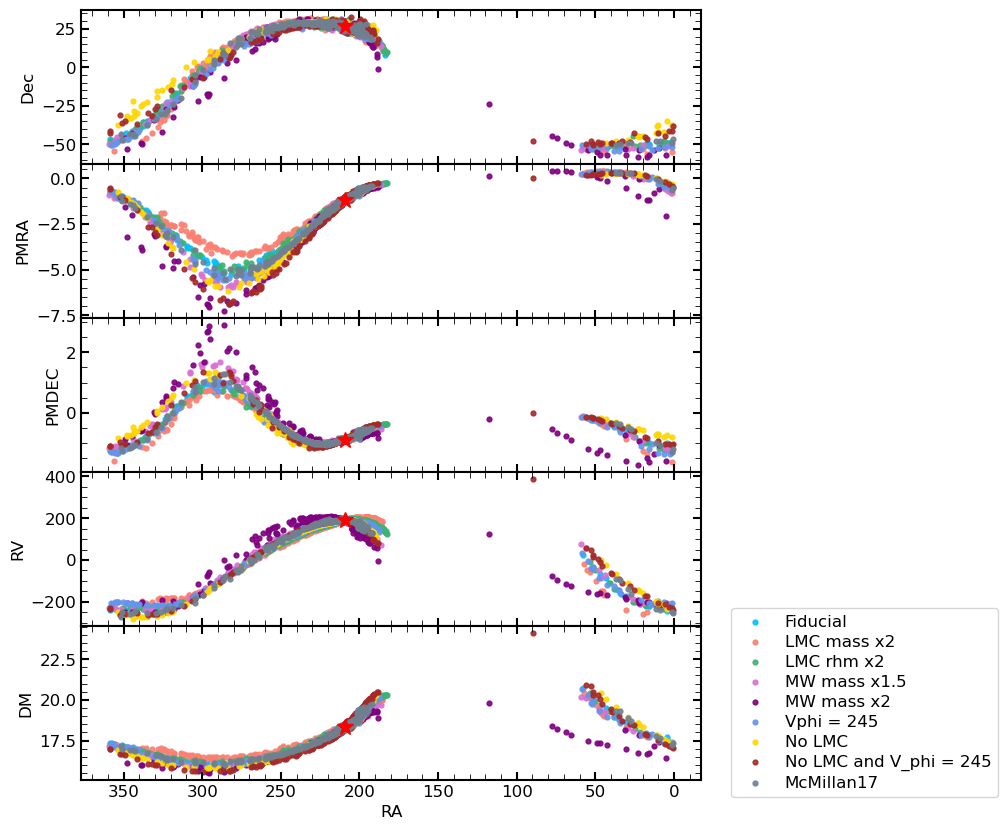

In [23]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i in range(len(orbit_results)):
    plot_five_params(ax, *orbit_results[i], s=12, c=_colours[i], label=_names[i], alpha=0.9)

for ax_i, label, value in zip(ax, ["Dec", "PMRA", "PMDEC", "RV", "DM"], 
                              [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")
    
ax[4].legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize=12)
plt.show()

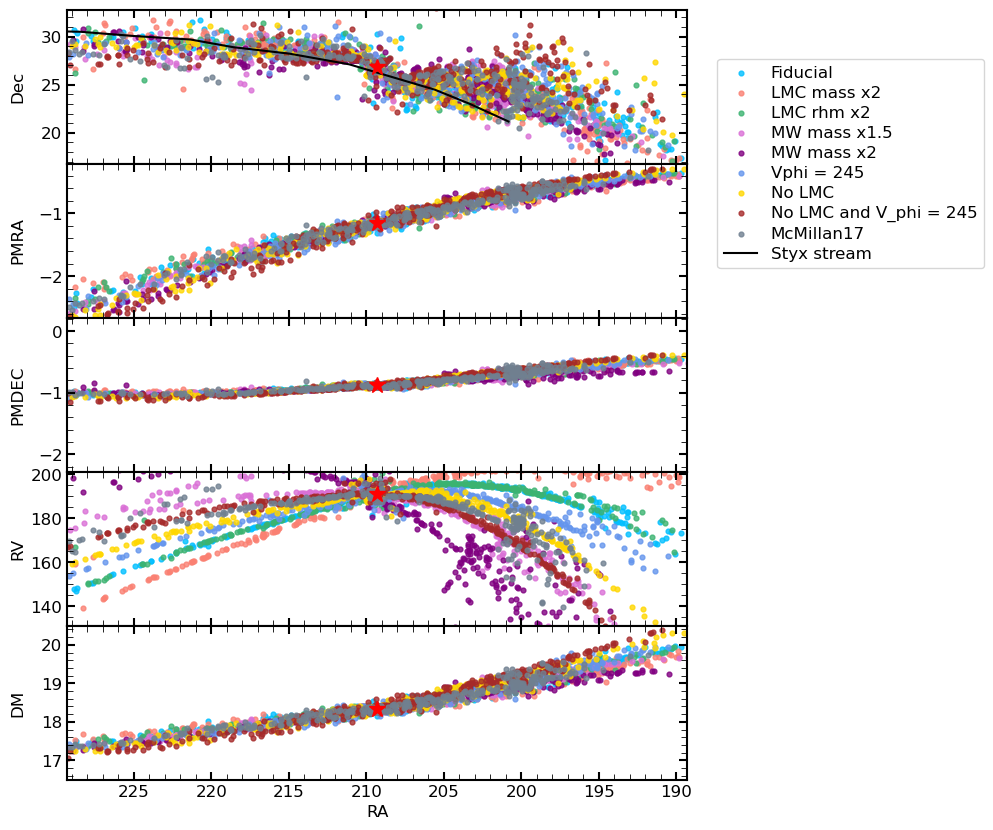

In [24]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i in range(len(orbit_results)):
    plot_five_params(ax, *orbit_results[i], s=12, c=_colours[i], label=_names[i], alpha=0.8)

#plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
    
for ax_i, label, value, scale in zip(ax, ["Dec", "PMRA", "PMDEC", "RV", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")

fig.align_ylabels(ax)
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

## Plotting the curves fitted onto the data points

In [36]:
from scipy.optimize import curve_fit

def get_model_curves(orbit_lead, orbit_trail, trim_range):
    ra = np.append(orbit_lead.ra(), orbit_trail.ra())
    dec = np.append(orbit_lead.dec(), orbit_trail.dec())
    pmra = np.append(orbit_lead.pmra(), orbit_trail.pmra())
    pmdec = np.append(orbit_lead.pmdec(), orbit_trail.pmdec())
    vlos = np.append(orbit_lead.vlos(), orbit_trail.vlos())
    dm = distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist()))
    
    trim = (trim_range[0] < ra) & (ra < trim_range[1])
    
#     def poly_func(x, a, b, c, d):
#         y = a * x**3 + b * x**2 + c * x + d
#         return y

    def poly_func(x, a, b, c):
        y = a * x**2 + b * x + c
        return y

    p_opt_dec, _ = curve_fit(poly_func, ra[trim], dec[trim])
    p_opt_pmra, _ = curve_fit(poly_func, ra[trim], pmra[trim])
    p_opt_pmdec, _ = curve_fit(poly_func, ra[trim], pmdec[trim])
    p_opt_vlos, _ = curve_fit(poly_func, ra[trim], vlos[trim])
    p_opt_dm, _ = curve_fit(poly_func, ra[trim], dm[trim])

    x = np.arange(*trim_range, 0.1)

    # Make the model curves
    curve_pmra = np.array([x, poly_func(x, *p_opt_pmra)]).T
    curve_pmdec = np.array([x, poly_func(x, *p_opt_pmdec)]).T
    curve_rv = np.array([x, poly_func(x, *p_opt_vlos)]).T
    curve_dm = np.array([x, poly_func(x, *p_opt_dm)]).T
    curve_dec = np.array([x, poly_func(x, *p_opt_dec)]).T
    
    return [curve_dec, curve_pmra, curve_pmdec, curve_rv, curve_dm]

In [37]:
orbit_curves = [[] for _ in range(9)]
for i in range(len(orbit_results)):
    orbit_curves[i].extend(get_model_curves(*orbit_results[i], [RA_BOO3-20, RA_BOO3+20]))

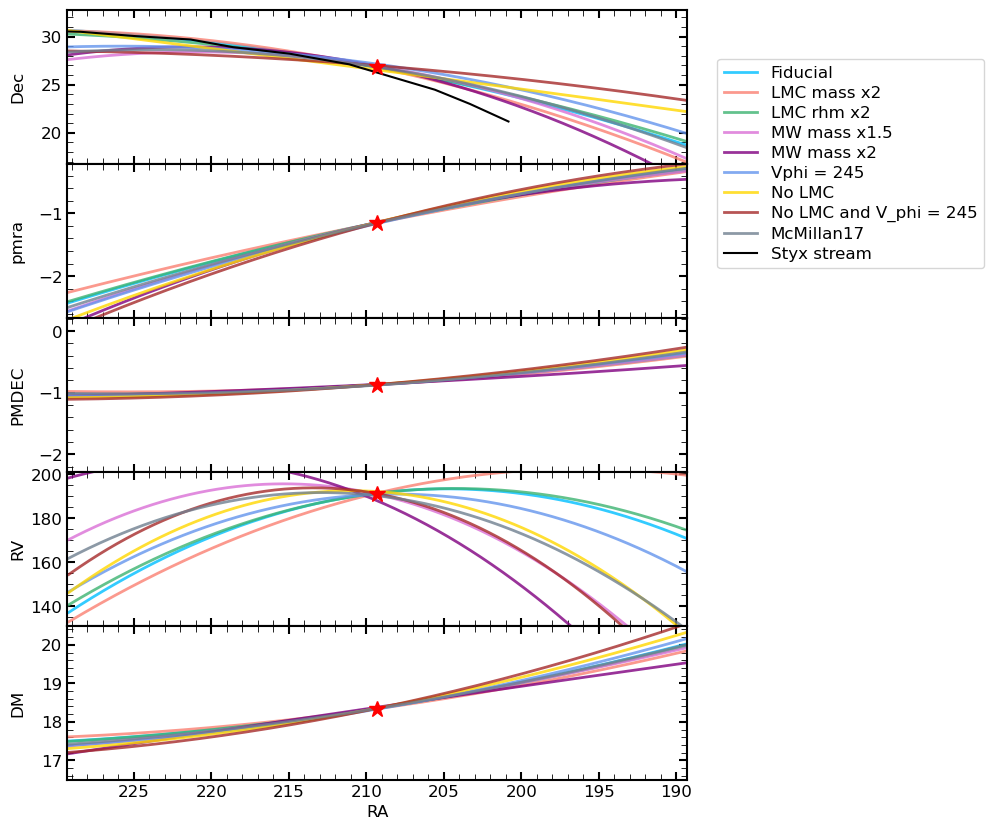

In [38]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for curve, colour, name in zip(orbit_curves, _colours, _names):
    plot_five_curves(ax, curve, c=colour, label=name, alpha=0.8, lw=2)

#plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
    
for ax_i, label, value, scale in zip(ax, ["Dec", "pmra", "PMDEC", "RV", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")

fig.align_ylabels(ax)
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

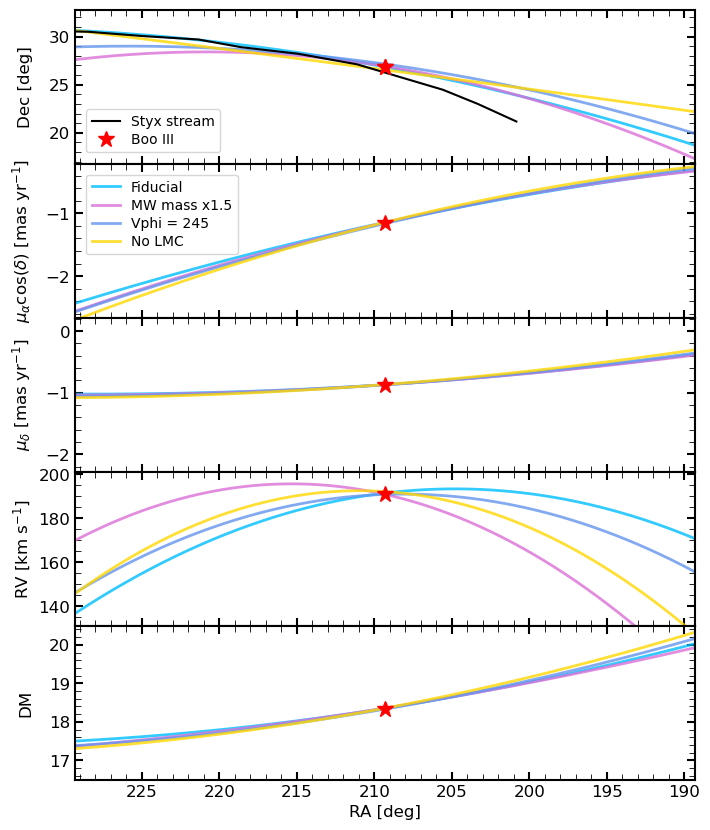

In [39]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

for i in range(len(orbit_curves)):
    if i in [0, 3, 5, 6]:
        plot_five_curves(ax, orbit_curves[i], no_label_ax0=True, c=_colours[i], label=_names[i], alpha=0.8, lw=2)

#plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III', ms=12)
ax[4].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
#fig.savefig('stream_comparison_selected.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Plotting each curve & data pairs

In [40]:
def _plot_special(ax, lead, trail, curve, **kwargs):
    ax[0].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.dec(), trail.dec()), marker='.', alpha=0.8, label='Fiducial data', **kwargs)
    ax[1].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.pmra(), trail.pmra()), marker='.', alpha=0.8, **kwargs)
    ax[2].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.pmdec(), trail.pmdec()), marker='.', alpha=0.8, **kwargs)
    ax[3].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.vlos(), trail.vlos()), marker='.', alpha=0.8, **kwargs)
    ax[4].scatter(np.append(lead.ra(), trail.ra()), distance_to_dm(1000 * np.append(lead.dist(), trail.dist())), marker='.', alpha=0.8, **kwargs)

    ax[0].plot(curve[0][:,0], curve[0][:,1], lw=2, c='deepskyblue', label='Fiducial curve', **kwargs)
    ax[1].plot(curve[1][:,0], curve[1][:,1], lw=2, c='deepskyblue', **kwargs)
    ax[2].plot(curve[2][:,0], curve[2][:,1], lw=2, c='deepskyblue', **kwargs)
    ax[3].plot(curve[3][:,0], curve[3][:,1], lw=2, c='deepskyblue', **kwargs)
    ax[4].plot(curve[4][:,0], curve[4][:,1], lw=2, c='deepskyblue', **kwargs)

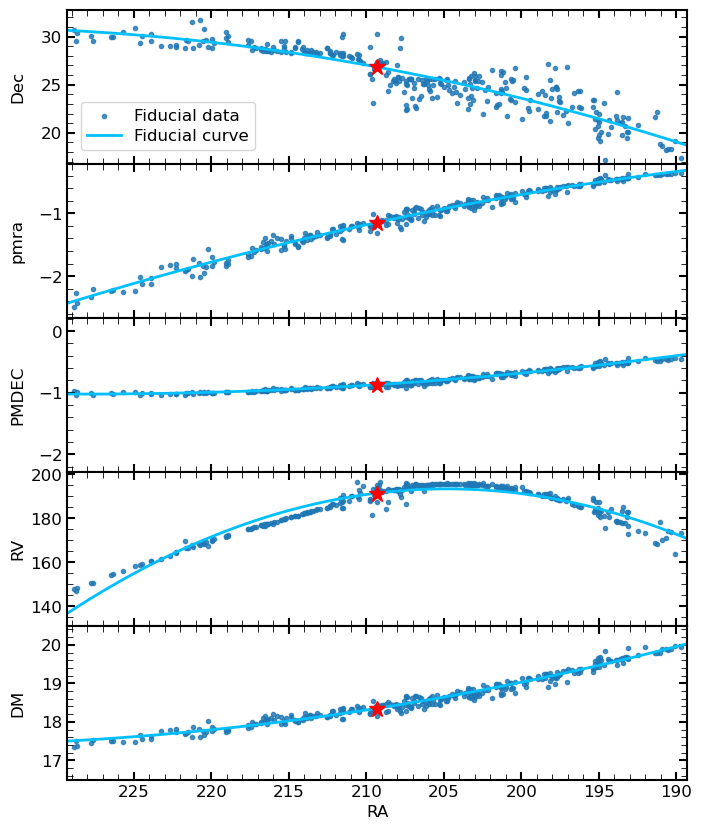

In [41]:
labels = ["Dec", "pmra", "PMDEC", "RV", "DM"]
values = [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)]
scales = [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
          (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

_plot_special(ax, *orbit_results[0], orbit_curves[0])

for ax_i, label, value, scale in zip(ax, labels, values, scales):
    ax_i.plot(RA_BOO3, value, "*r", ms=12)
    ax_i.set_ylabel(label)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA")

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=12)
plt.show()

In [42]:
def plot_curve_and_data(ax, lead, trail, curve, **kwargs):
    ax[0].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.dec(), trail.dec()), marker='.', **kwargs)
    ax[1].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.pmra(), trail.pmra()), marker='.', **kwargs)
    ax[2].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.pmdec(), trail.pmdec()), marker='.', **kwargs)
    ax[3].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.vlos(), trail.vlos()), marker='.', **kwargs)
    ax[4].scatter(np.append(lead.ra(), trail.ra()), distance_to_dm(1000 * np.append(lead.dist(), trail.dist())), marker='.', **kwargs)

    kwargs.pop('alpha', 1)
    kwargs.pop('c', 'k')
    ax[0].plot(curve[0][:,0], curve[0][:,1], **kwargs)
    ax[1].plot(curve[1][:,0], curve[1][:,1], **kwargs)
    ax[2].plot(curve[2][:,0], curve[2][:,1], **kwargs)
    ax[3].plot(curve[3][:,0], curve[3][:,1], **kwargs)
    ax[4].plot(curve[4][:,0], curve[4][:,1], **kwargs)

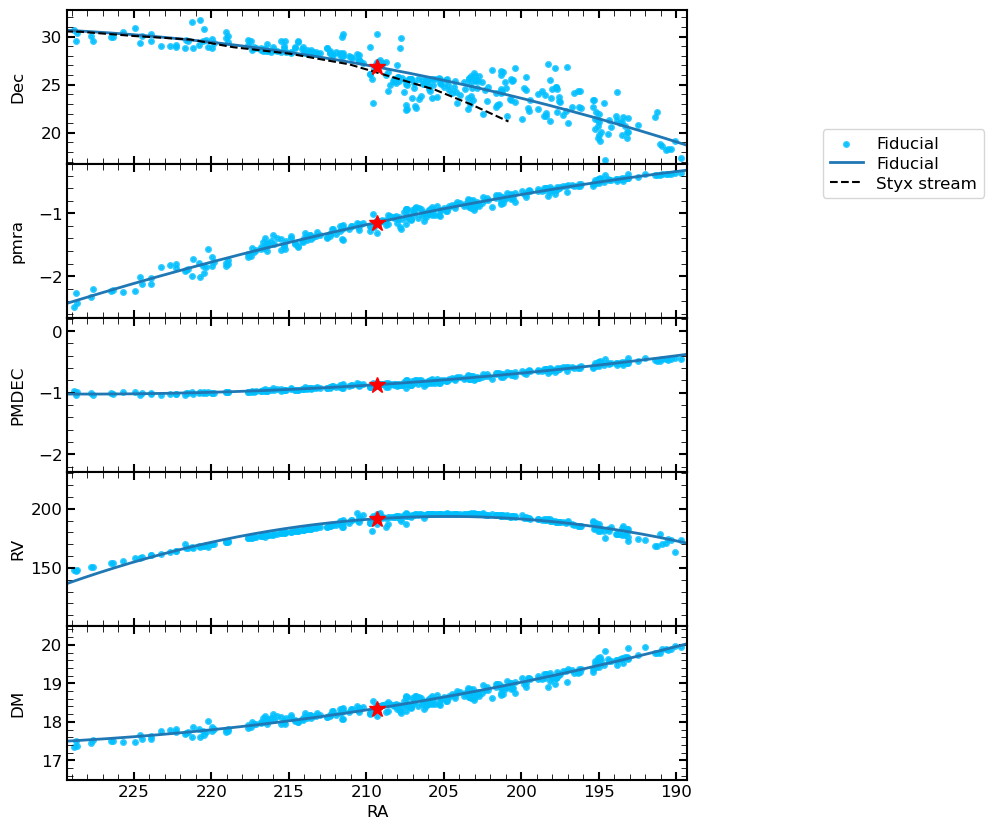

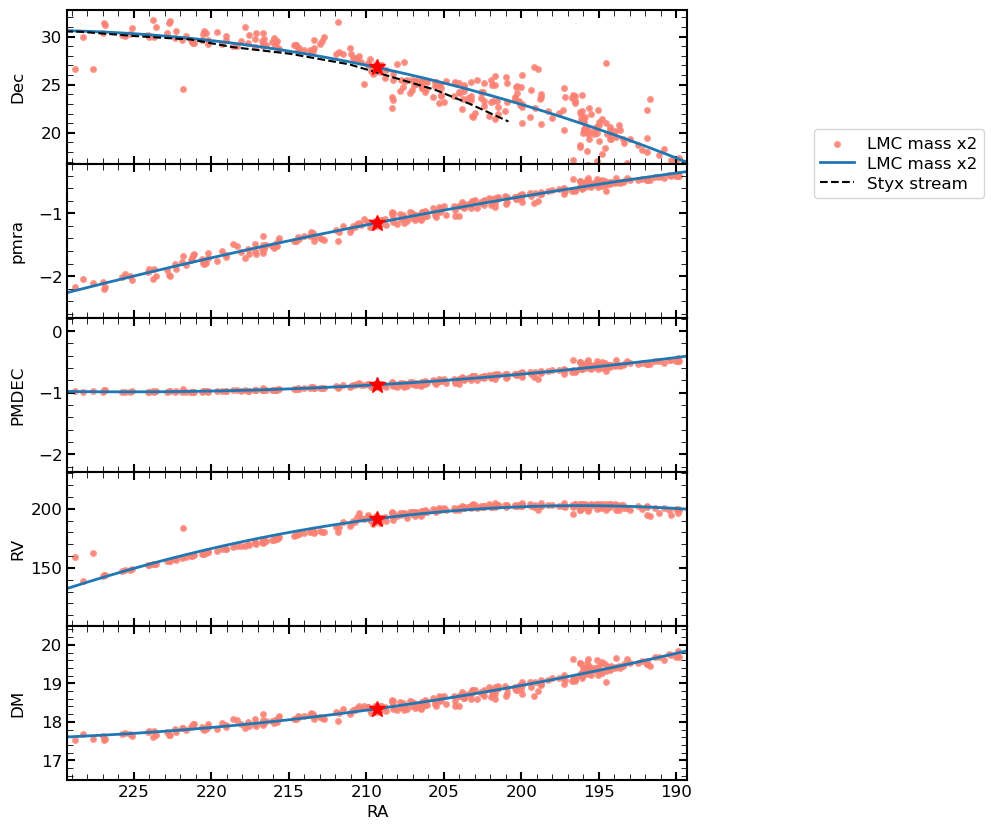

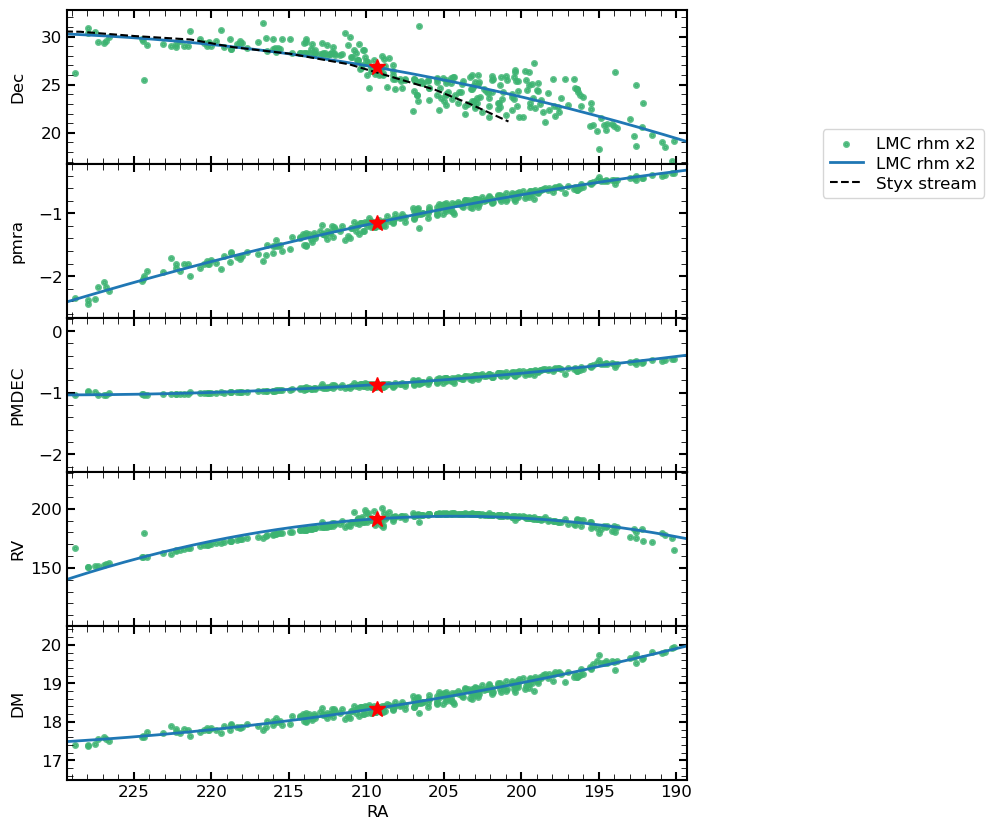

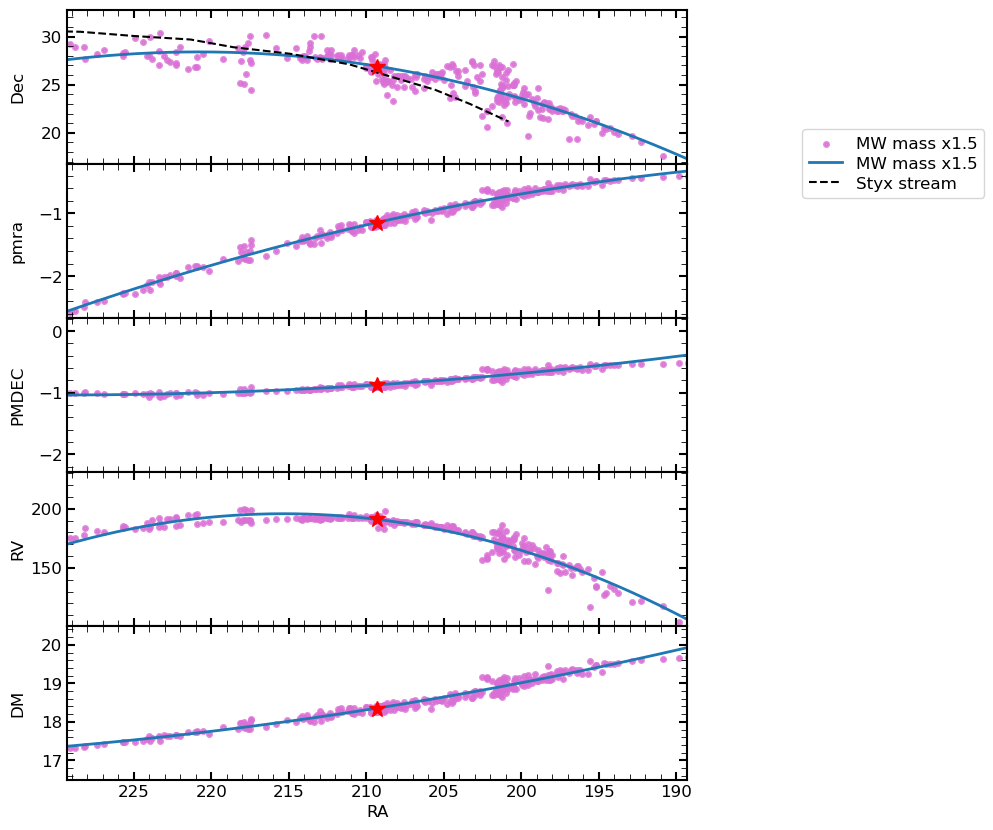

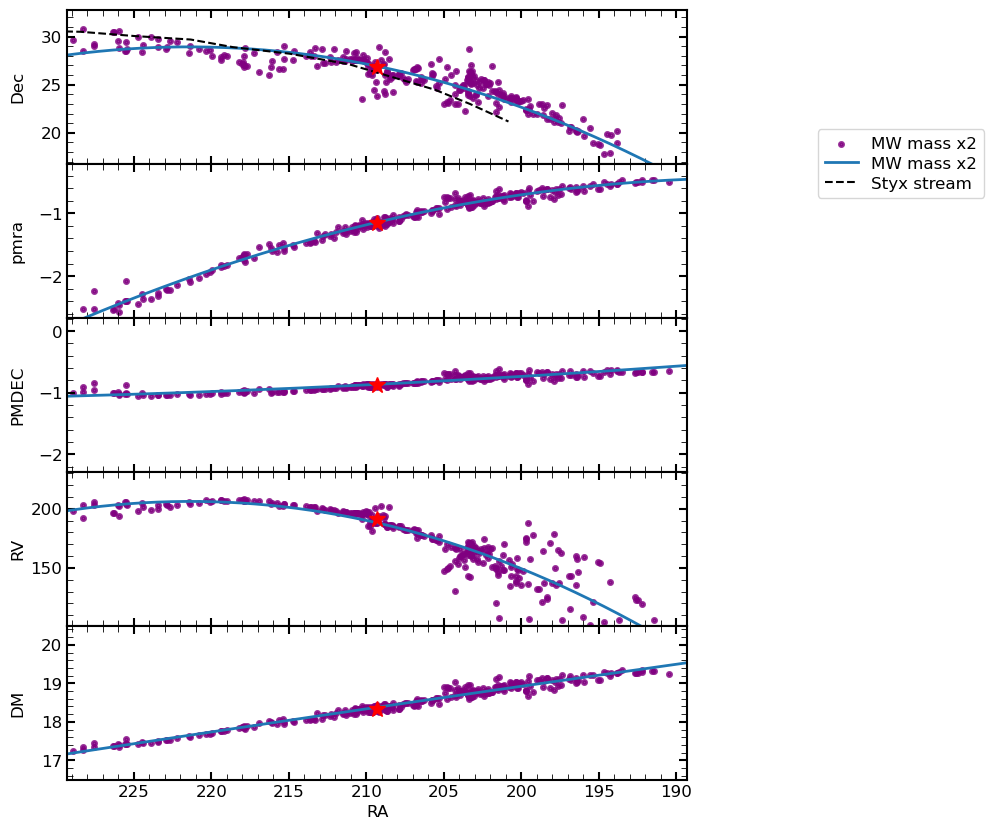

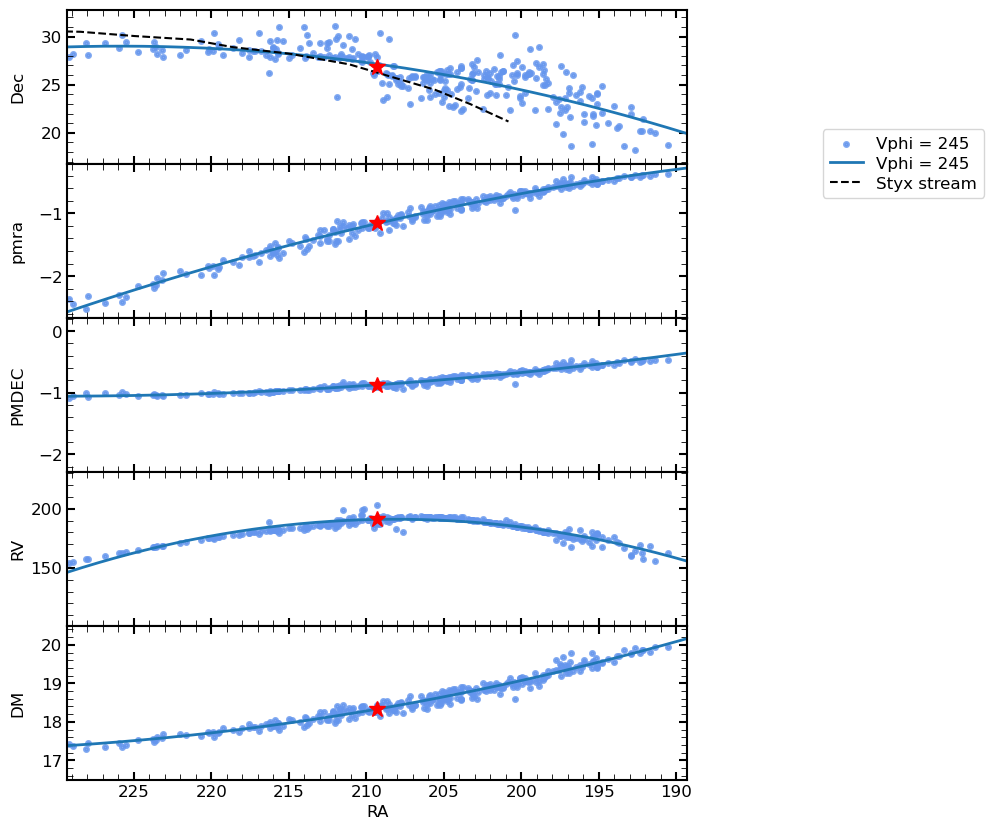

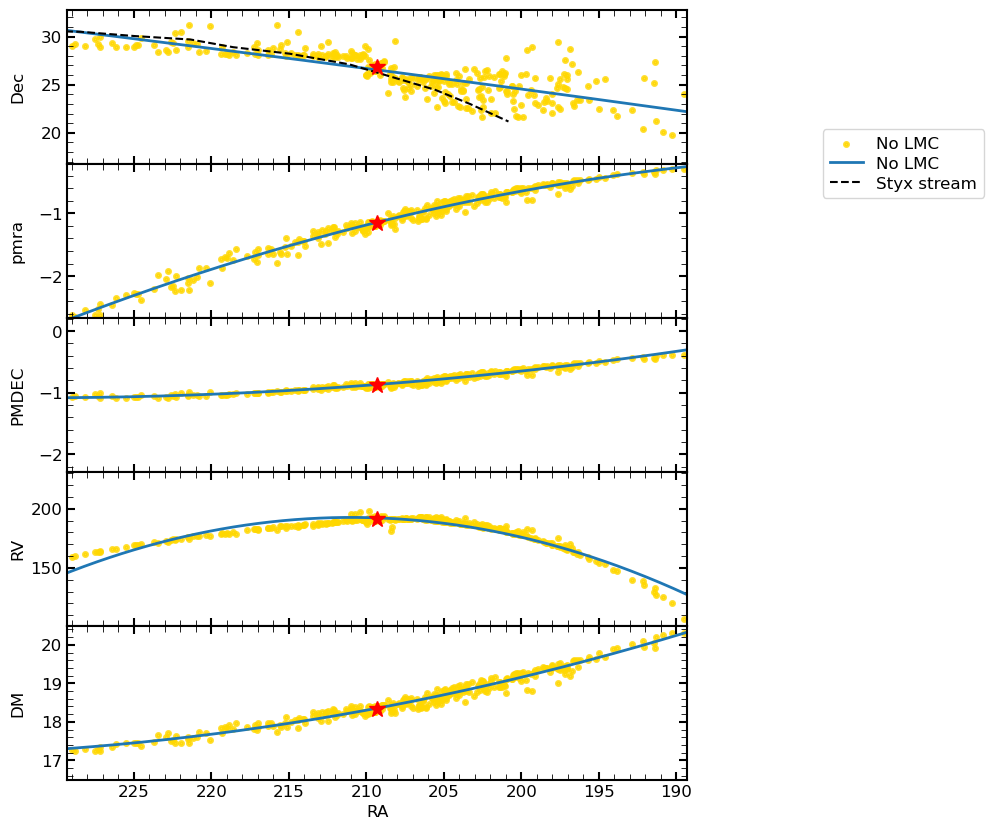

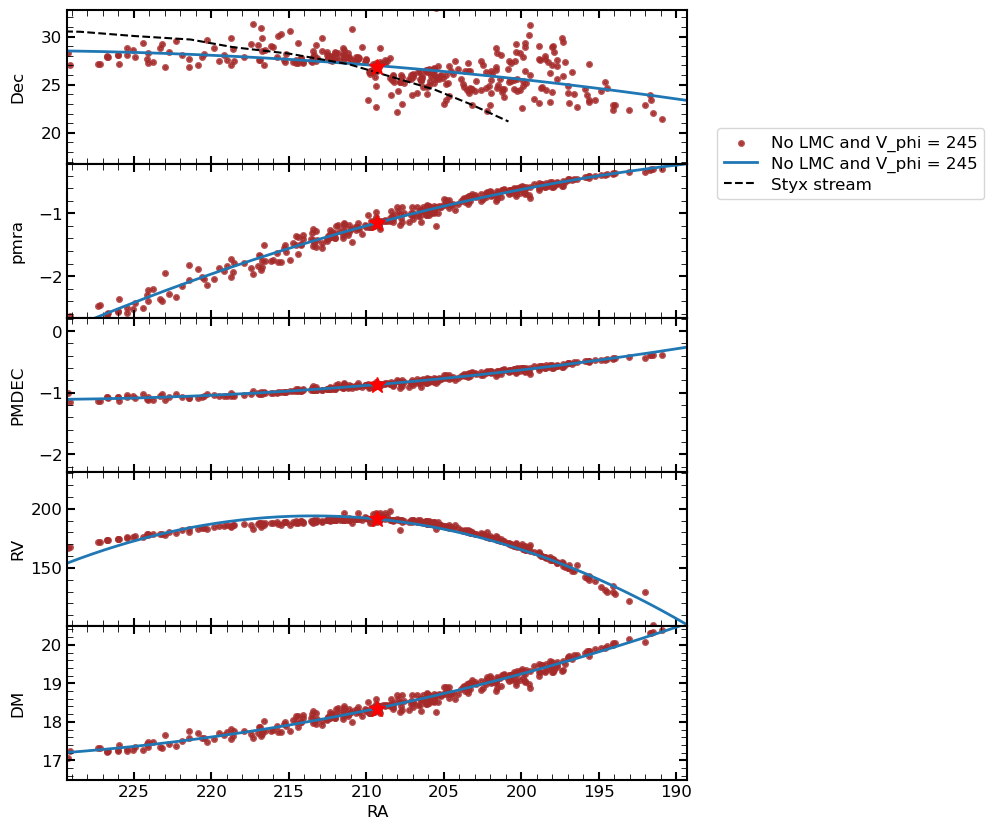

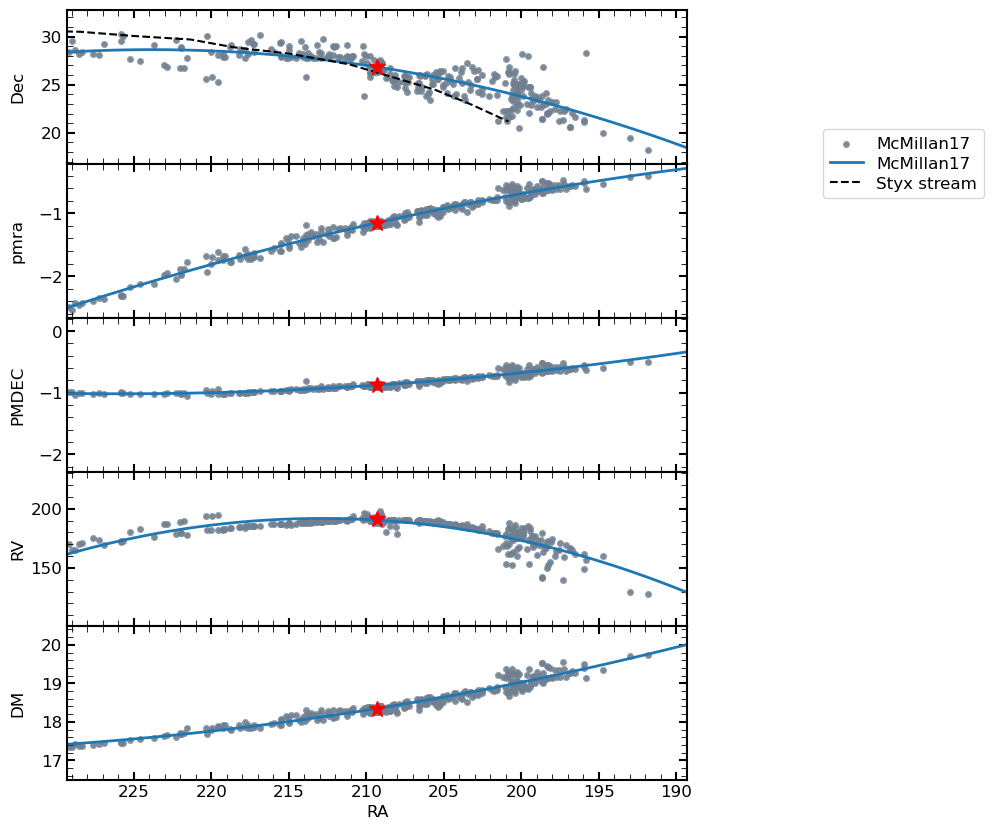

In [43]:
labels = ["Dec", "pmra", "PMDEC", "RV", "DM"]
values = [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)]
scales = [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
          (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60-30, VEL_BOO3+10+30), (16.5, 20.5)]

for data, curve, colour, name in zip(orbit_results, orbit_curves, _colours, _names):
    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
    fig.subplots_adjust(hspace=0)
    
    plot_curve_and_data(ax, data[0], data[1], curve, c=colour, label=name, alpha=0.8, lw=2)
    ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k--', label='Styx stream')
    
    for ax_i, label, value, scale in zip(ax, labels, values, scales):
        ax_i.plot(RA_BOO3, value, "*r", ms=12)
        ax_i.set_ylabel(label)
        ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
        ax_i.set_ylim(*scale)
        ax_i.invert_xaxis()
    ax[4].set_xlabel("RA")

    fig.align_ylabels(ax)
    ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0), fontsize=12)
    plt.show()